In [1]:
import numpy as np
import meanderpy as mp
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
mpl.rcParams['figure.dpi'] = 1000

In [2]:
def uniform_resample(x, y, z, ds):
    seg_len = np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2)
    s_old   = np.insert(np.cumsum(seg_len), 0, 0.0)
    s_new   = np.arange(0.0, s_old[-1], ds)

    x_new = np.interp(s_new, s_old, x)
    y_new = np.interp(s_new, s_old, y)
    z_new = np.interp(s_new, s_old, z)
    return x_new, y_new, z_new

def bennettin_meander_multi(freq, amp, delta_y,
                             n_pert=1,
                             nit_total=501, reset_interval=501, saved_ts=1,
                             seed=None):
    
    rng = np.random.default_rng(seed)

    W, D = 50.0, 1.0
    x0   = np.linspace(0.1, 10_000, 1500)
    y0   = amp * 100.0 * np.sin(freq * np.pi * x0 / 10_000.0)
    z0   = np.zeros_like(x0)

    ch_ref = mp.Channel(x0.copy(), y0.copy(), z0.copy(), W, D)
    cb_ref = mp.ChannelBelt([ch_ref], [], [0.0], [])

    cb_pert = []
    for _ in range(n_pert):
        y1 = y0.copy()
        idx = rng.integers(1, len(y1) - 1)
        y1[idx] += delta_y
        cb_pert.append(mp.ChannelBelt([mp.Channel(x0.copy(), y1, z0.copy(), W, D)],
                                      [], [0.0], []))

    depths = D * np.ones(nit_total)
    Cfs    = 0.0065 * np.ones(nit_total)
    pad, deltas, crdist = 0, 50.0, 5 * W
    kl   = 500.0 / (365*24*60*60)
    kv   = 1e-12
    dt   = 0.1 * 0.5 * 365*24*60*60
    dens = 1000
    t1 = t2 = t3 = aggr = 0

    ref_channels  = [ch_ref]
    pert_channels = [[belt.channels[0]] for belt in cb_pert]

    steps = 0
    while steps < nit_total:
        n = min(reset_interval, nit_total - steps)

        cb_ref.migrate(n, saved_ts, deltas, pad, crdist,
                       depths[steps:steps+n], Cfs[steps:steps+n],
                       kl, kv, dt, dens, t1, t2, t3, aggr)

        for belt in cb_pert:
            belt.migrate(n, saved_ts, deltas, pad, crdist,
                         depths[steps:steps+n], Cfs[steps:steps+n],
                         kl, kv, dt, dens, t1, t2, t3, aggr)

        ref_channels.extend(cb_ref.channels[-n:])
        for i, belt in enumerate(cb_pert):
            pert_channels[i].extend(belt.channels[1:])

        steps += n
        if steps == nit_total:
            break

        last = cb_ref.channels[-1]
        x_mid, y_mid, z_mid = last.x.copy(), last.y.copy(), last.z.copy()

        ds_target = W / 2.0
        for i in range(n_pert):
            idx = rng.integers(1, len(y_mid) - 1)
            y_seed = y_mid.copy()
            y_seed[idx] += delta_y

            x_u, y_u, z_u = uniform_resample(x_mid, y_seed, z_mid, ds_target)

            ch_seed = mp.Channel(x_u, y_u, z_u, W, D)
            cb_pert[i] = mp.ChannelBelt([ch_seed], [], [0.0], [])
            pert_channels[i].append(cb_pert[i].channels[0])

    return ref_channels, pert_channels

In [7]:
ref_chs, pert_chs_list = bennettin_meander_multi(
    freq=30.0, amp=3.0, delta_y=1e-10,
    n_pert=100, nit_total=501, seed=42
)

100%|██████████| 501/501 [00:02<00:00, 243.32it/s]


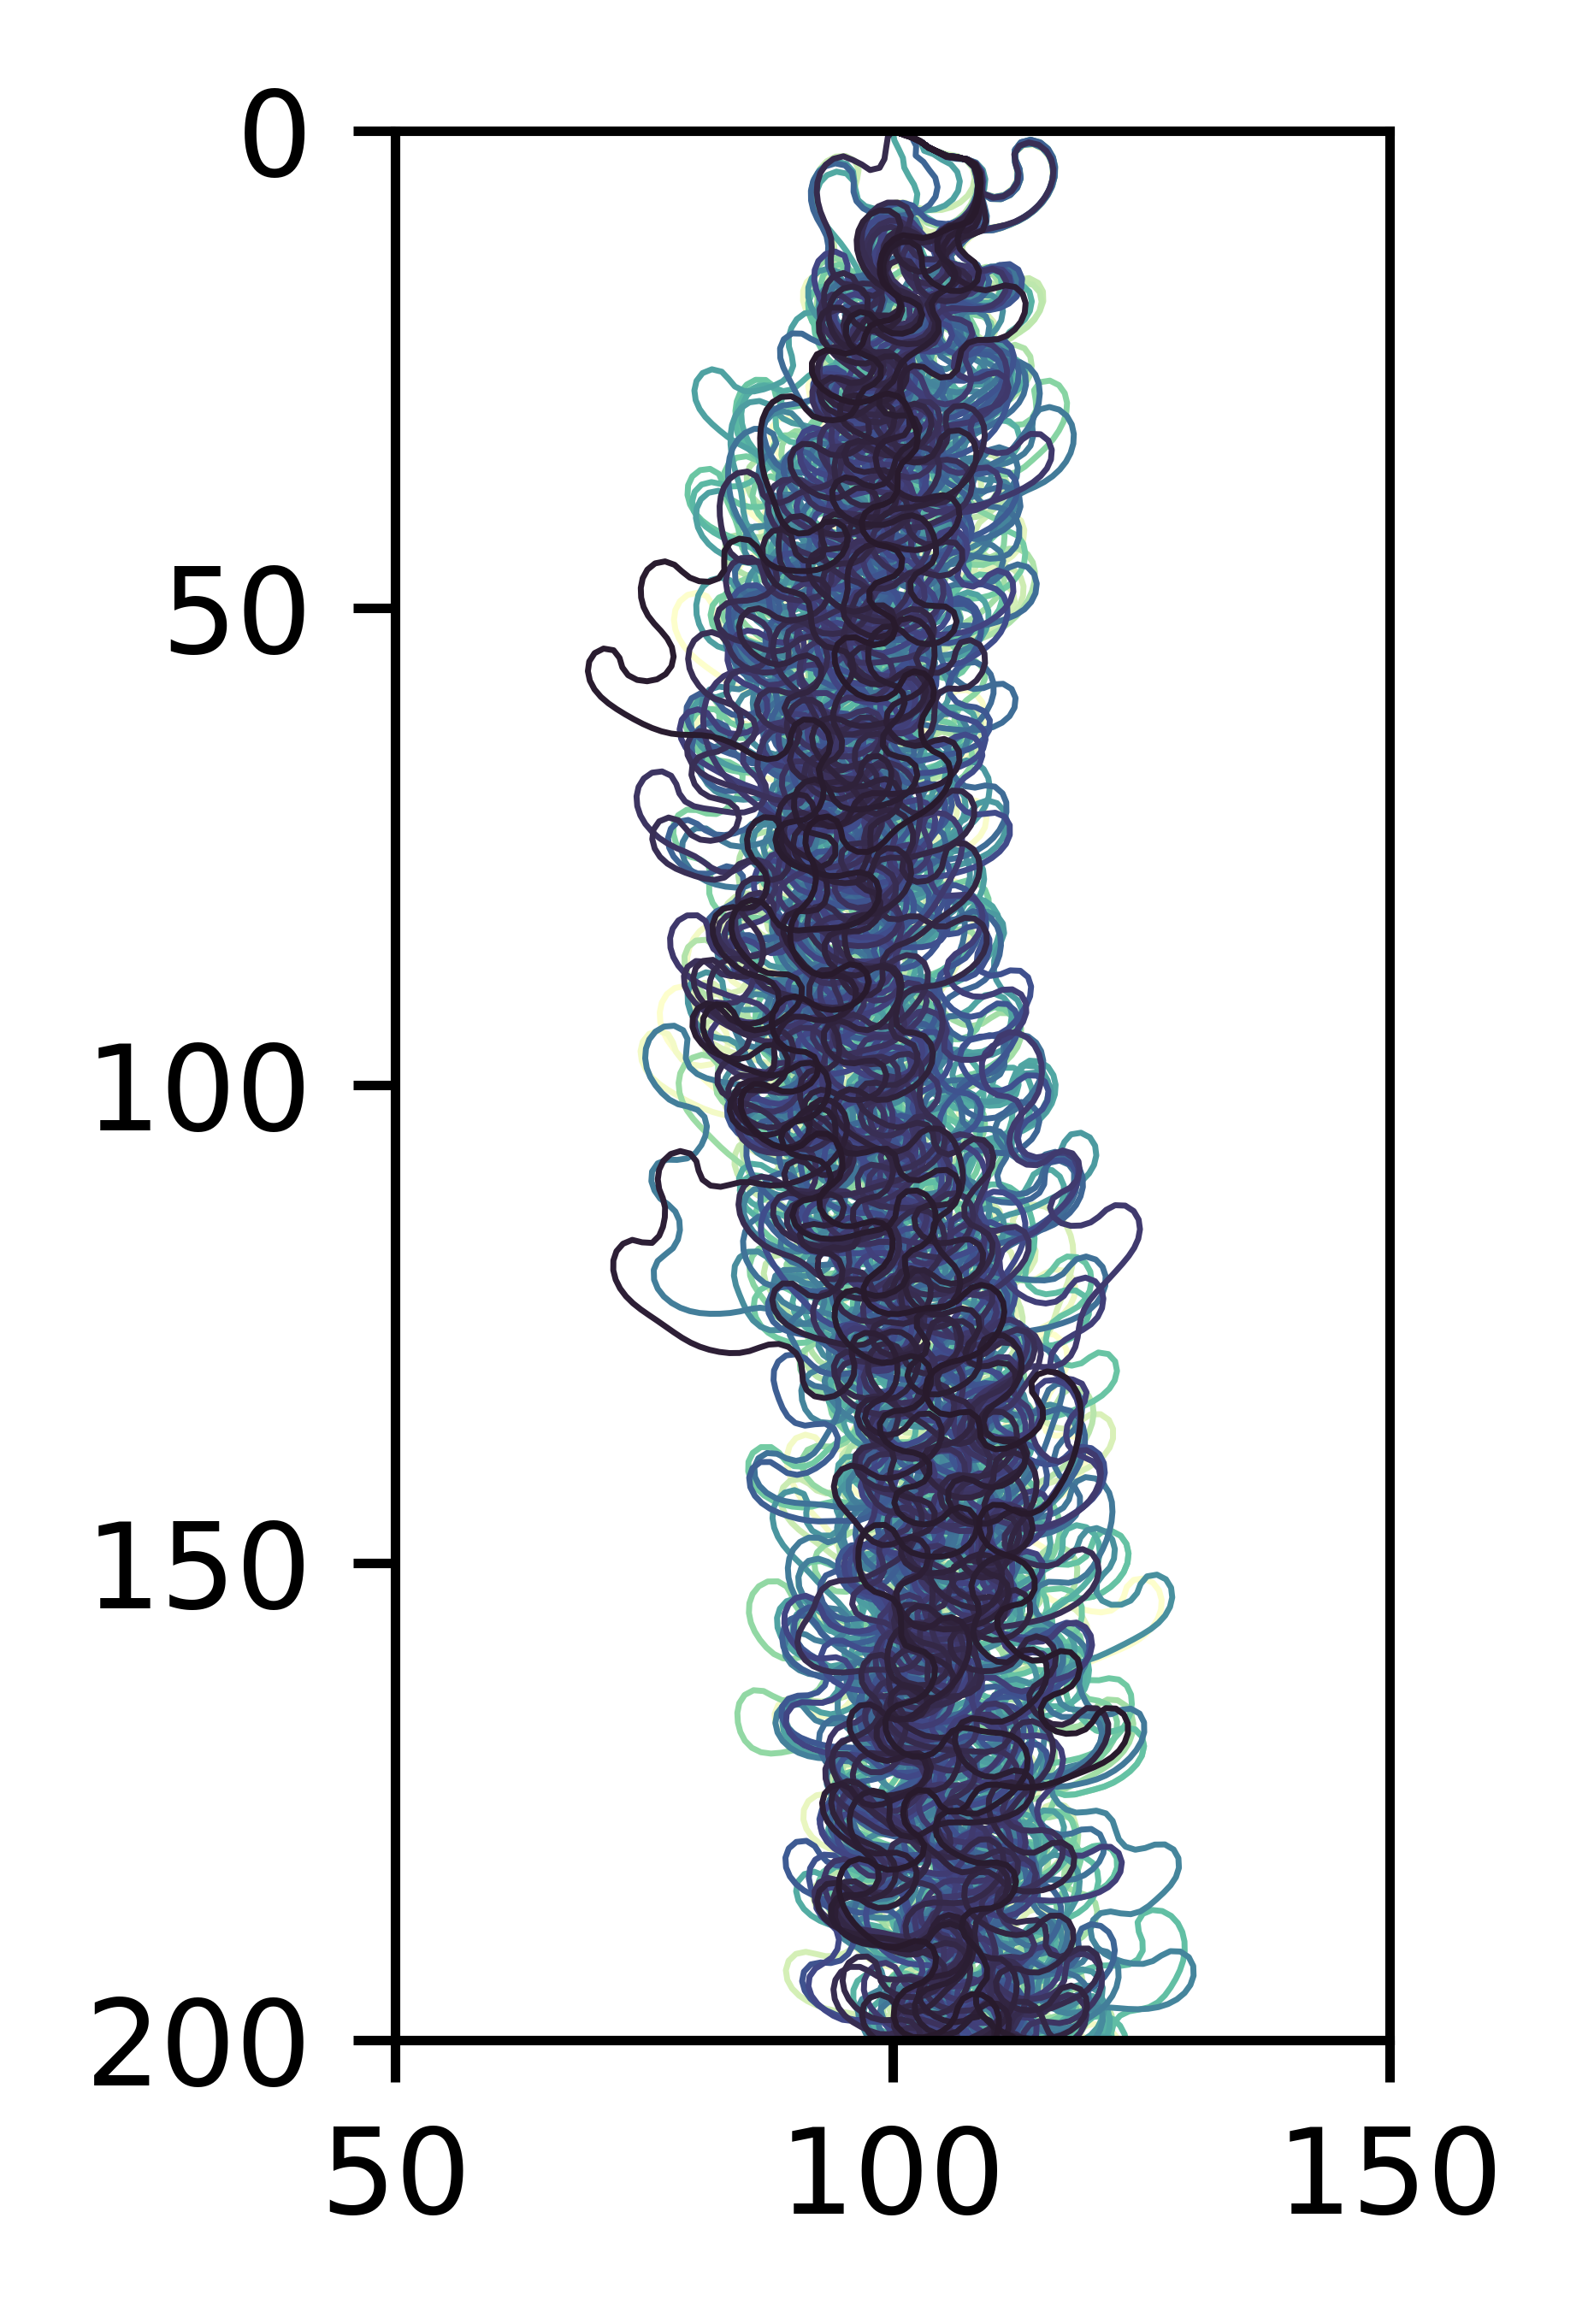

In [10]:
timestep = 500

fig, ax = plt.subplots(figsize=(1.5, 2.9))

cmap = cmocean.cm.deep
n_channels = len(pert_chs_list)
colors = cmap(np.linspace(0, 1, n_channels))

for color, run in zip(colors, pert_chs_list):
    ch = run[timestep]
    ax.plot(ch.y/50 + 100, ch.x/50, lw=0.5, color=color, alpha=1)

ax.set_xlim([50, 150])
ax.set_ylim([200, 0])
ax.set_yticks([200, 150, 100, 50, 0])
ax.set_xticks([50, 100, 150])

plt.show()

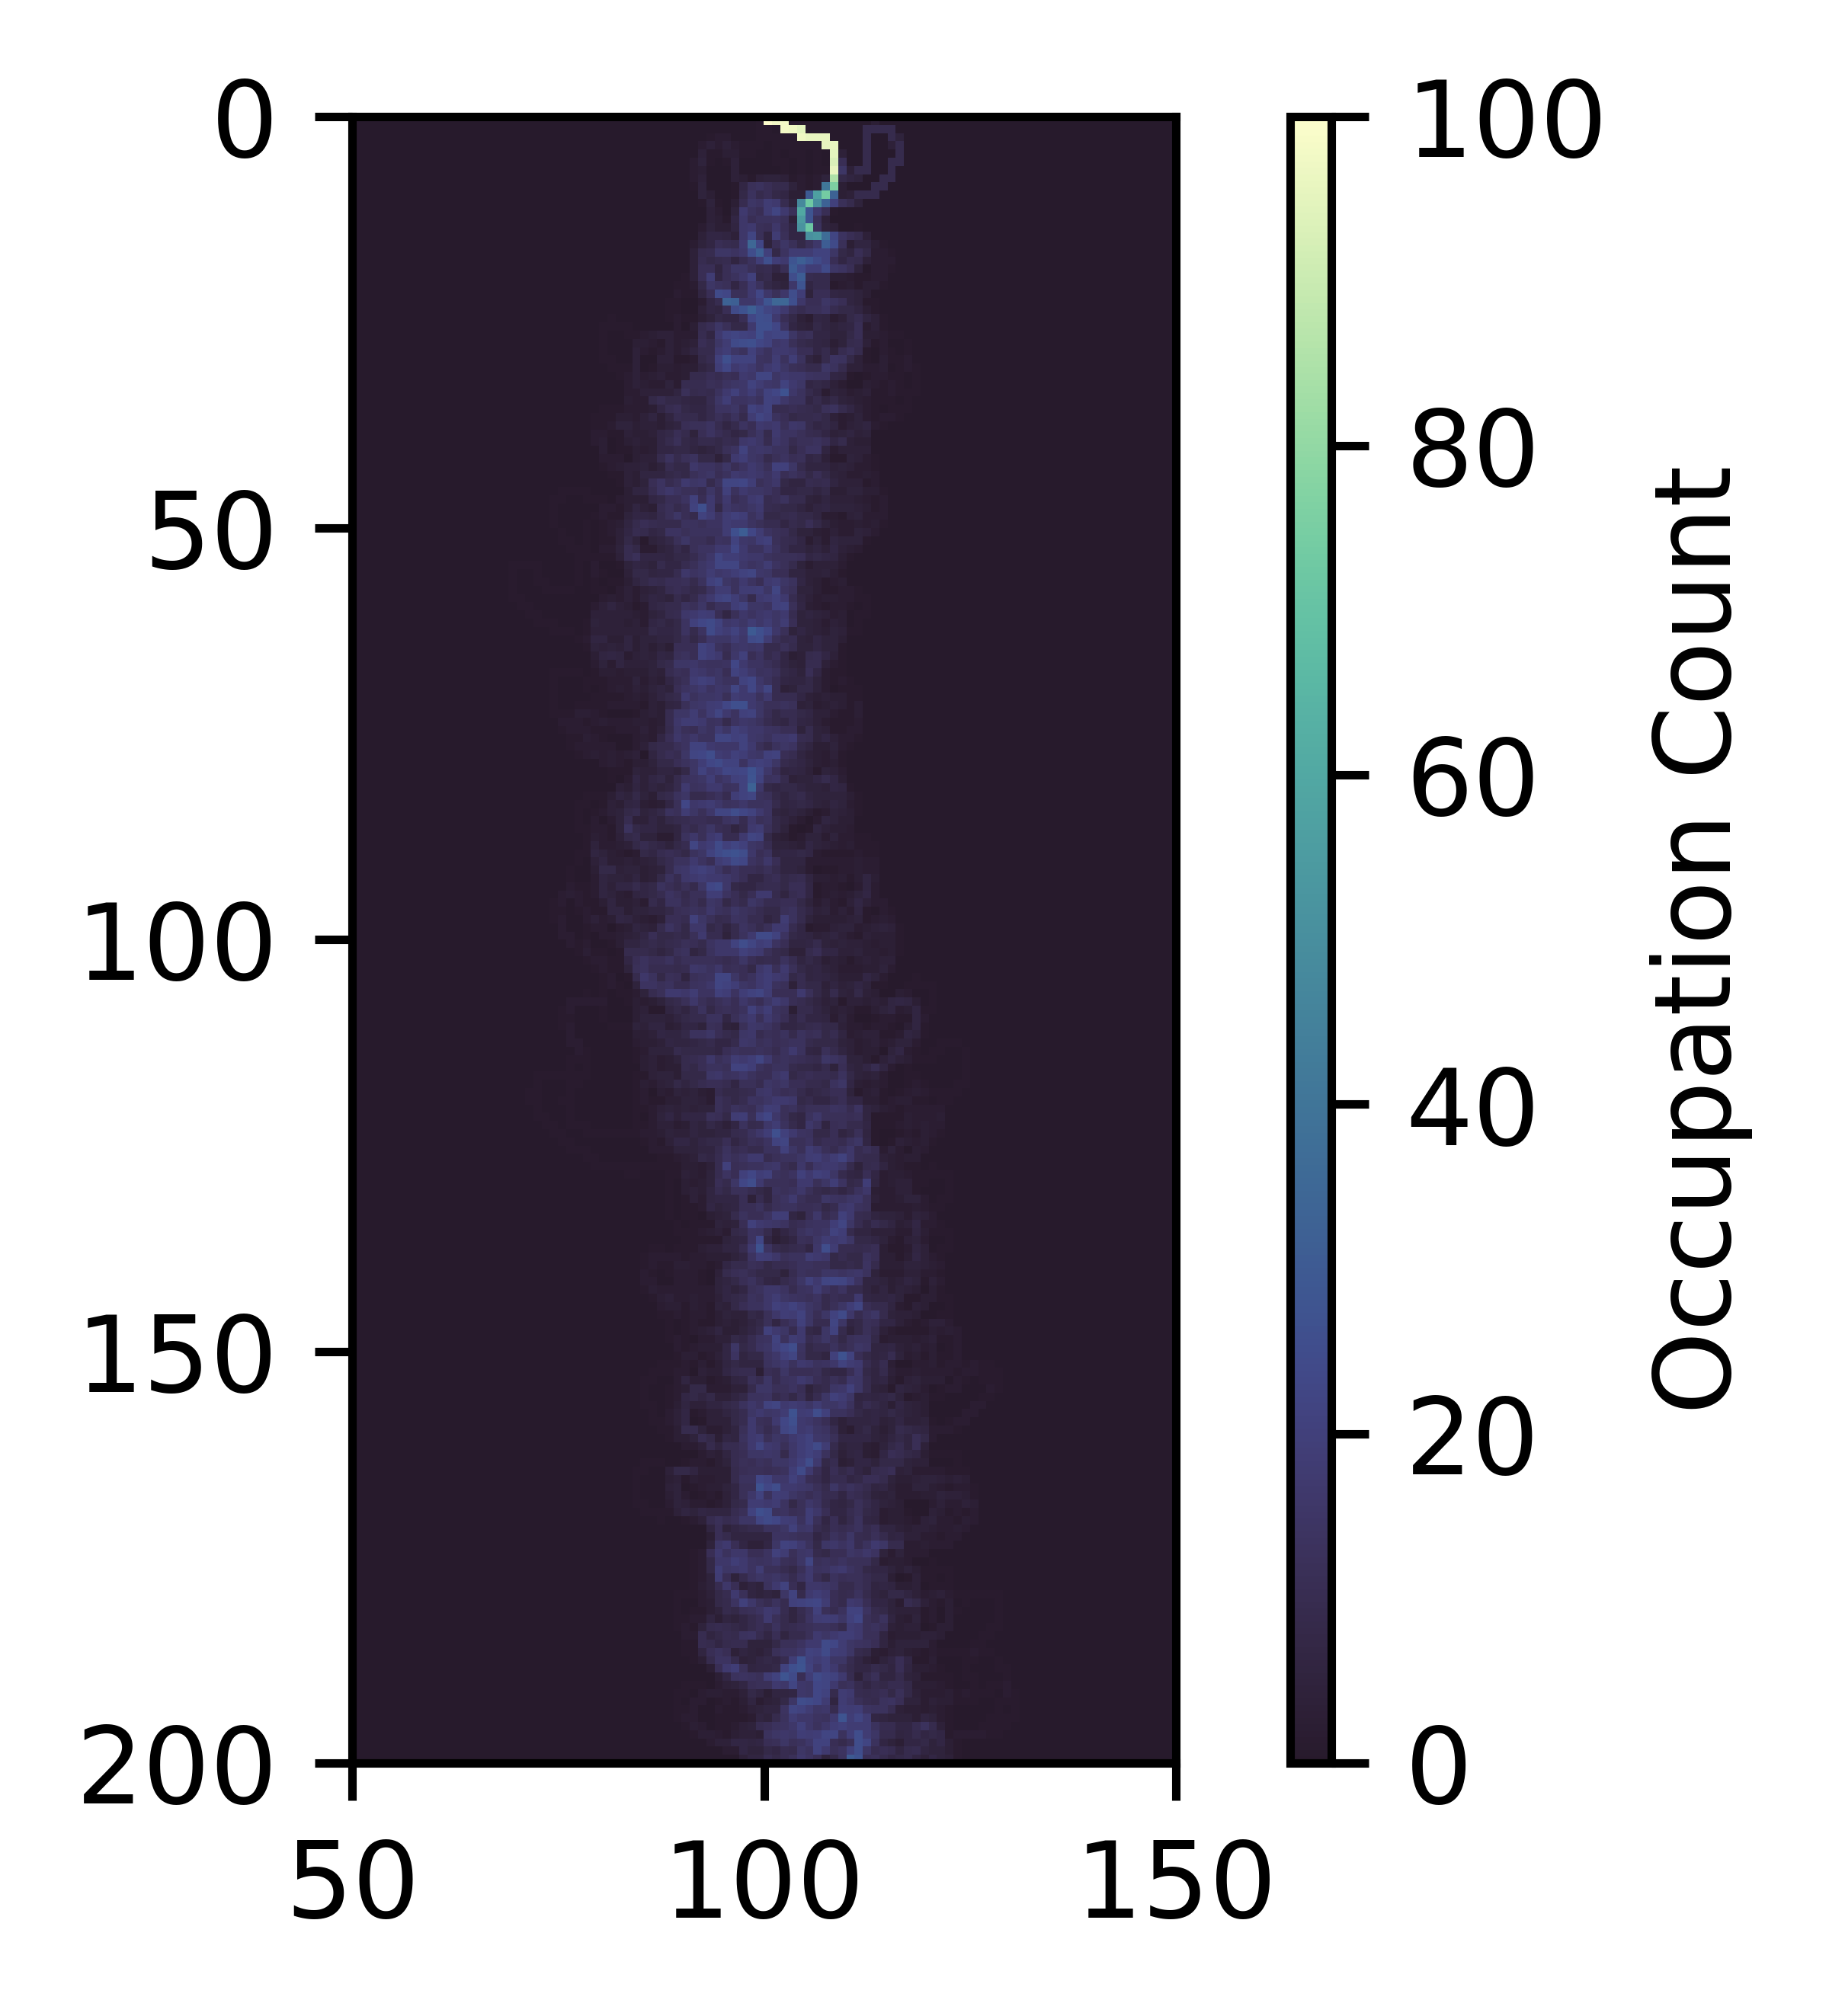

In [11]:
x_min, x_max = 0, 10000
y_min, y_max = -5000, 5000
rows = cols = 200
dx = (x_max - x_min) / cols
dy = (y_max - y_min) / rows

timestep = 500

def increment_channel(x, y, canvas, n_seg=10):
    temp = np.zeros_like(canvas, dtype=bool)
    for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:]):
        xs = np.linspace(x0, x1, n_seg)
        ys = np.linspace(y0, y1, n_seg)
        c = ((xs - x_min) / dx).astype(int)
        r = ((ys - y_min) / dy).astype(int)
        mask = (0 <= c) & (c < cols) & (0 <= r) & (r < rows)
        temp[r[mask], c[mask]] = True
    c = ((x - x_min) / dx).astype(int)
    r = ((y - y_min) / dy).astype(int)
    mask = (0 <= c) & (c < cols) & (0 <= r) & (r < rows)
    temp[r[mask], c[mask]] = True
    canvas += temp.astype(np.uint16)

count_canvas = np.zeros((rows, cols), dtype=np.uint16)

for run in pert_chs_list:
    ch = run[timestep]
    increment_channel(ch.x, ch.y, count_canvas)

rot180 = count_canvas.T[::1, ::1]

fig, ax = plt.subplots(figsize=(2.5, 5))

im = ax.imshow(
    rot180,
    cmap=cmocean.cm.deep_r,
    vmin=0,
    vmax=len(pert_chs_list),
    origin='upper',
    extent=[0, rot180.shape[1], rot180.shape[0], 0]
)

ax.set_xlim([50, 150])
ax.set_ylim([200, 0])
ax.set_xticks([50, 100, 150])
ax.set_yticks([200, 150, 100, 50, 0])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Occupation Count")

plt.tight_layout()
plt.show()

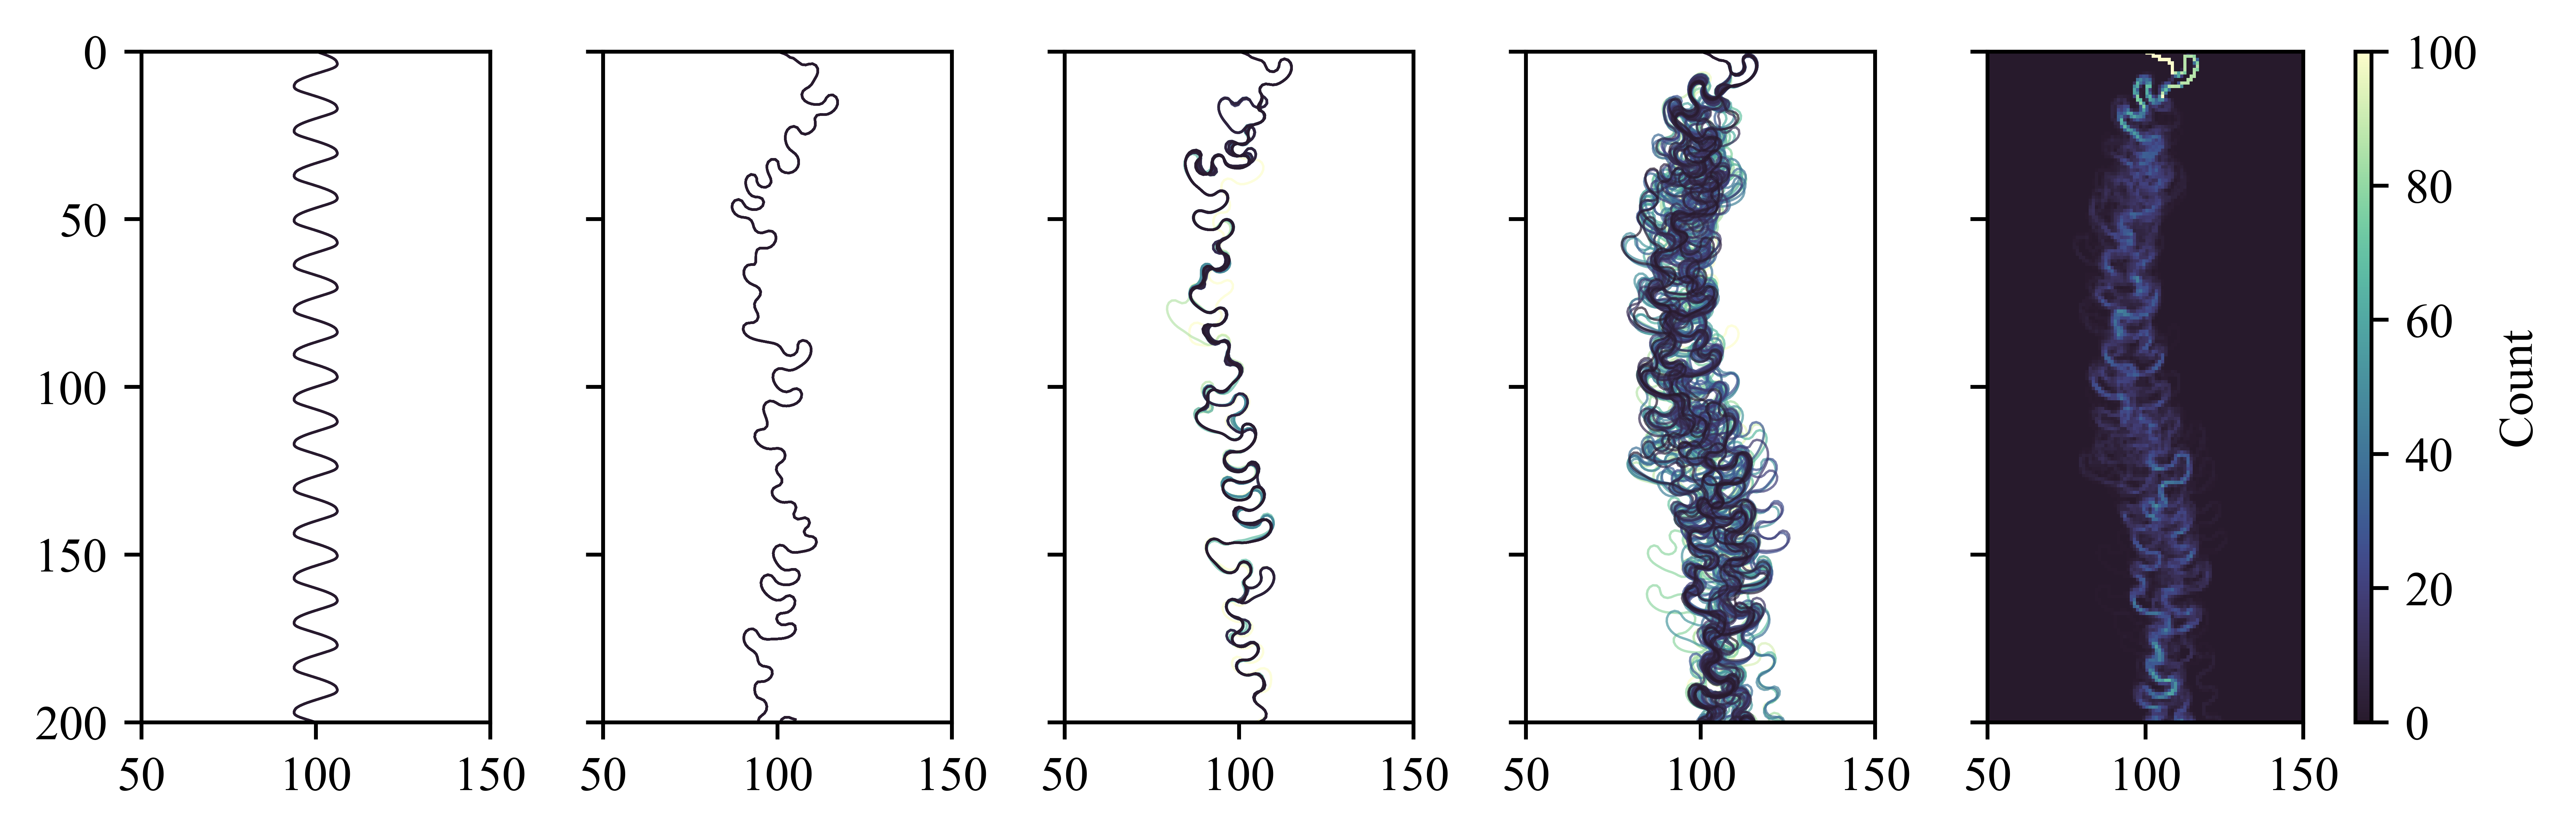

In [46]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

timesteps = [0, 150, 350, 450]

fig, axes = plt.subplots(1, 5, figsize=(7.5, 2.5), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 1, 1, 1, 1.1]})
xlim = [50, 150]
ylim = [200, 0]

cmap = cmocean.cm.deep
n_channels = len(pert_chs_list)
colors = cmap(np.linspace(0, 1, n_channels))

for idx, timestep in enumerate(timesteps):
    ax = axes[idx]
    for color, run in zip(colors, pert_chs_list):
        ch = run[timestep]
        ax.plot(ch.y / 50 + 100, ch.x / 50, lw=0.5, color=color, alpha=0.7)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([50, 100, 150])
    ax.set_yticks([200, 150, 100, 50, 0])
    ax.set_aspect('auto')

count_canvas = np.zeros((rows, cols), dtype=np.uint16)
for run in pert_chs_list:
    ch = run[450]
    increment_channel(ch.x, ch.y, count_canvas)

rot180 = count_canvas.T[::1, ::1]

ax = axes[-1]
im = ax.imshow(
    rot180,
    cmap=cmocean.cm.deep_r,
    vmin=0,
    vmax=len(pert_chs_list),
    origin='upper',
    extent=[0, rot180.shape[1], rot180.shape[0], 0],
    aspect='auto'
)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticks([50, 100, 150])
ax.set_yticks([200, 150, 100, 50, 0])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Count")

fig.tight_layout()
plt.savefig("/Users/braydennoh/Downloads/chaosriver1.svg", format="svg")
plt.show()